# Matches

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob
import lalsimulation as lalsim
from nrutils.analyze.match import match as match_object

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"
(pwca.core)>> Metadata dictionary for Ed's catalog paper stored to "pwca.catalog_paper_metadata"


In [2]:

#
package_dir = parent( pwca.__path__[0] )
datadir = package_dir + 'data/version2/'
files = glob( datadir+'q*.txt' )

#
fref = 20

#
q_list = []
for a in pwca_catalog:
    q_list.append( int( round(a.m1/a.m2,2) ) )
mask = argsort(q_list)
pwca_catalog = array(pwca_catalog)[mask]

match_list = []
mod_phenomd_match_list = []
kk = 0
for a in pwca_catalog:
    
    #
    file_ = [ k for k in files if a.simname in k ][0]
    
    #
    Msol = 100.0
    Dmpc = 1000.0
    #
    theta = 0
    phi   = 0
    #
    fmin = 30.0
    fmax = 300.0
    
    # Load data for this case
    raw_data = loadtxt(file_)
    f,amp_td,amp_fd,dphi_td,dphi_fd,phi_td,phi_fd = raw_data.T
    hcode_ = amp_td * exp( 1j * phi_td ) * sYlm(-2,2,2,theta,phi)
    hcode = array([f,hcode_*0.5,hcode_*0.5*1j]).T

    # Generate NR FD waveform array
    # ------------------------------------------------ #
    mask = f>0
    f     = f[mask]
    hcode = hcode[mask,:]
    hphys = physhf(hcode,Msol,Dmpc)

    # Generate MODEL FD waveform array
    # ------------------------------------------------ #
    
    if linalg.norm(a.X1)<1e-3:
        m1,m2 = a.m2,a.m1
        X1,X2 = a.X2,a.X1
        a.m1,a.m2 = m1,m2
        a.X1,a.X2 = X1,X2
    
    # External 2-spin mapping
    chi_p    = calc_chi_p(a.m1,a.X1,a.m2,a.X2,a.L)
    a1,model_theta = calc_effective_a1_theta( a.m1, a.m2, a.X1, a.X2, a.L )
    # Find index location of metadata for simname 
    k = [ z.split('.')[0] for z in pwca.metadata_dict['simname'] ].index(a.simname.split('.')[0])
    model_theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = pwca.metadata_dict['array_data'][k]
    
    # Generate a coprecessing waveform as 1D array (NEW INPUT STRUCTURE)
    hmodel = generate_pwca_waveform_helper( f, model_theta, eta, a1, chi1,chi2, chi_p, fref=fref ) * sYlm(-2,2,2,theta,phi)
    
    # Generate a coprecessing waveform as 1D array
    #hmodel = generate_pwca_waveform( f, a.m1, a.m2, a.X1, a.X2, a.L ) * sYlm(-2,2,2,theta,phi)
    #print sum(abs(hmodel-hmodel_old))/sum(abs(hmodel_old))
    
    hmodel_p = 0.5*(hmodel)
    hmodel_c = -1j*0.5*(hmodel)
    hcode_model = array([f,hmodel_p,hmodel_c]).T
    hphys_model = physhf( hcode_model,Msol,Dmpc )
    
    #
    mod_phenomd = generate_modified_phenomd(f, a.m1, a.m2, a.X1, a.X2, a.L)
    mod_phenomd_p = 0.5*(mod_phenomd)
    mod_phenomd_c = -1j*0.5*(mod_phenomd)
    mod_phenomd_code = array([f,mod_phenomd_p,mod_phenomd_c]).T
    mod_phenomd_phys = physhf( mod_phenomd_code,Msol,Dmpc )

    #
    phys_signal   = hphys
    phys_template = hphys_model

    # Create match object
    mo = match_object( phys_template,    phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
    moo= match_object( mod_phenomd_phys, phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )

    mx  = mo.calc_template_pol_optimized_match()
    mxd = moo.calc_template_pol_optimized_match()
    print a.simname.replace('_','')[:16],'\t\t\t',1-mx,'\t\t\t',1-mxd,'\t\t\t',mxd>mx
    match_list.append(mx)
    mod_phenomd_match_list.append(mxd)

q1a04t120dP0T965 			0.00019003460107991366 			0.000420151064270069 			False
q1a08t90dPm1T964 			0.00027450575248766373 			0.0013368559278359449 			False
q1a08t30dPm25T96 			0.00031642419889865714 			0.0008840036659910622 			False
q1a04t60dPm1T965 			0.00015933772423049053 			0.0003962375734257728 			False
q1a08t60dPm1.5T9 			0.0006863924169985269 			0.0016123477473330983 			False
q1a08t120dP0T964 			0.0006505099187400498 			0.001078280037638879 			False
q1a08t150dP0T964 			0.00027445884412835575 			0.00036431348871035496 			False
q1a04t30dPm2T965 			0.00015484113089081486 			0.00029645793244625906 			False
q1a04t150dP0T965 			0.00021304470805050268 			0.0004645584666579383 			False
q1a04t90dP0T9655 			0.0007751928122083918 			0.0006121575161448511 			True
q2a04t30dPm2T964 			0.00017001992701859425 			0.00047249446348518465 			False
q2a04t120T96408 			0.00013902804099941157 			0.00014188277866844512 			False
q2a04t150T96408 			9.384667953937775e-05 			0.00010369964739864734 			False
q2a

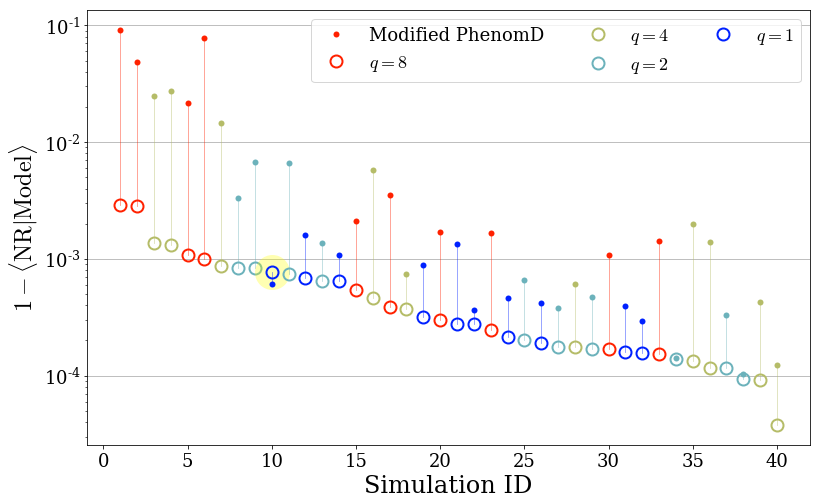

In [3]:

figure(figsize=2*figaspect(0.618))

mask = argsort(match_list)

clr=rgb(4,jet=True)

q_set = [1,2,4,8][::-1]
passed_q = []
for k,a in enumerate(pwca_catalog[mask]):

    if mod_phenomd_match_list[ mask[k] ] > match_list[ mask[k] ]:
        plot( k+1, 1-match_list[ mask[k] ], mew=0, ms=35, ls='none', marker='o', color='yellow', alpha=0.3 )
        
    q = int( round(a.m1/a.m2,2) )
    plot( k+1, 1-mod_phenomd_match_list[ mask[k] ], mew=0, ms=6, ls='none', marker='o', color=clr[q_set.index(q)], label= 'Modified PhenomD' if not k else None )
    plot( k+1, 1-match_list[ mask[k] ], mew=2, ms=12, ls='none', marker='o', mfc='none', color=clr[q_set.index(q)], label= '$q=%i$'%q if not (q in passed_q) else None )
    plot( [k+1,k+1],[1-mod_phenomd_match_list[ mask[k] ],1-match_list[ mask[k] ]], color=clr[q_set.index(q)], alpha=0.5 )
    passed_q.append(q)
    
    #axhline(1e-2,ls='--',color='m')
    yscale('log')
    xlabel('Simulation ID')
    ylabel(r'$1-\langle \mathrm{NR} | \mathrm{Model} \rangle$')
    grid(True,axis='y')
    
    legend(ncol=3,frameon=True)
    
#
savefig('/Users/book/KOALA/puck/ll/data/version2/matches_diagnostic.pdf')

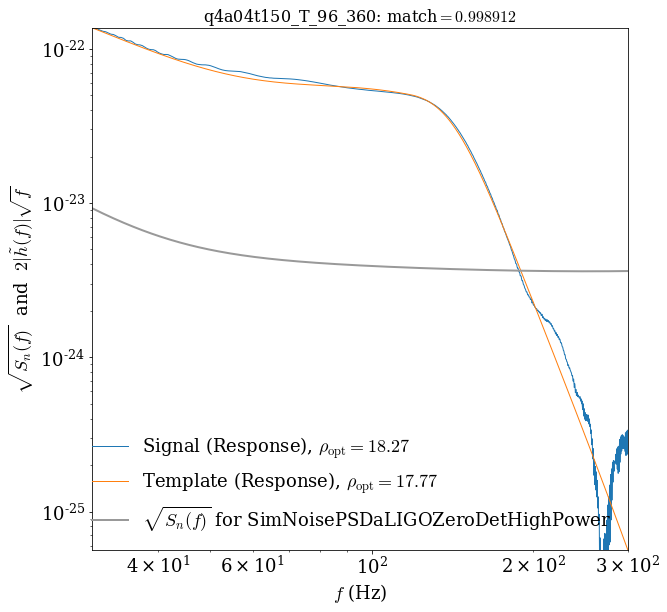

In [4]:
fig = mo.plot()
title('%s: match$=%f$'%(a.simname,mx));